# Prevalence inference
I came across this [paper](http://www.sciencedirect.com/science/article/pii/S1053811916303470) from Allefeld, Gorgen, & Haynes (2016) a while ago, in which they discuss that doing a second-level t-test on first-level (i.e., subject-level) classification accuracies (or any other information-based statistic) implies a fixed-effects analysis, which does not warrant any conclusion about a population-level effect (something we aim for in most cognitive neuroscience research). Fortunately, the authors put the code for the implementation of prevalence inference (in the context of MVPA) on [Github](https://github.com/allefeld/prevalence-permutation), albeit MATLAB-based. To understand how this algorithm works (and because no Python-implementation exists thus far), I decided to implement it here. (Also, I plan to incorporate it in my Python package [skbold](https://github.com/lukassnoek/skbold).)

First, some imports:

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook  # pip install tqdm
from scipy import stats
from scipy.io import savemat
from nilearn.plotting import plot_stat_map
%matplotlib inline

## Data
We'll simulate some artificial first-level data (i.e., classification accuracies). We'll simulate data for 20 subjects ($N = 20$) for $9 \times 10 \times 9 = 810$ voxels ($K = 810$; an artificially low number of voxels for searchlight-based first-level results, but speeds up the analysis). As such, the true ("observed") first-level data is of shape $20 \times 810$. Furthermore, let's assume that we also ran 100 first-level permutations ($P_{1}$) of the same analysis. As such, the shape of our permutation data is $20 \times 810 \times 100$. Note that this is a slightly different setup than in the original article, in which they treat the 'observed' data as the first permutation. Here, we keep the 'observed' and 'permuted' data separate.

We'll simulate the observed data as samples drawn from a normal distribution with mean 0.6 (i.e., classification accuracy of 60%) and standard deviation 0.05:

\begin{align}
observed = \mathcal{N}(0.55, .05)
\end{align}

Our permutation-data, on the other hand, will be drawn from a normal distribution with mean 0.5 and standard deviation of 0.05:

\begin{align}
permuted = \mathcal{N}(0.5, .05)
\end{align}

In [2]:
N = 20
K = (9, 10, 9)
P1 = 100

obs = np.random.normal(loc=0.55, scale=0.05, size=(N, np.prod(K)))
perms = np.random.normal(loc=0.5, scale=0.05, size=(N, np.prod(K), P1))

print("Observed values shape: %s" % (obs.shape,))
print("Perms shape: %s" % (perms.shape,))

Observed values shape: (20, 810)
Perms shape: (20, 810, 100)


## Analysis
In this section, we'll actually implement (step-by-step) the prevalence 

### Analysis params
First, let's set some analysis-wide parameters. We'll use an (uncorrected) significance threshold, $\alpha$, of 0.05 and we'll run 10000 second-level permutations ($P_{2}$). Again, $P_{2}$, here, refers to all 'permuted' second level data (i.e., we keep the 'observed' second level statistics separate and is thus not part of the permutations). Later, we'll use a prevalence null statistic, $\gamma_{0}$ of 0.5 (corresponding to the "majority null hypothesis").

In [3]:
alpha = 0.05
P2 = 10000
gamma0 = 0.5

### The minimum statistic
First, we need to calculate the minimum statistic ($m$), which we'll use as the second-level test-statistic. The minimum statistic for any voxel $v$ is calculated across our $N$ subjects with classification accuracies $\hat{a}_{k}$ as (cf. equation 11 from the paper):

\begin{align}
m_{v} = min_{k=1}^{N}\hat{a}_{vk}
\end{align}

In code (note, we'll calculate $m_{v}$ for all $v = 1\ ...\ 810$ voxels at once):

Shape of m: (810,)


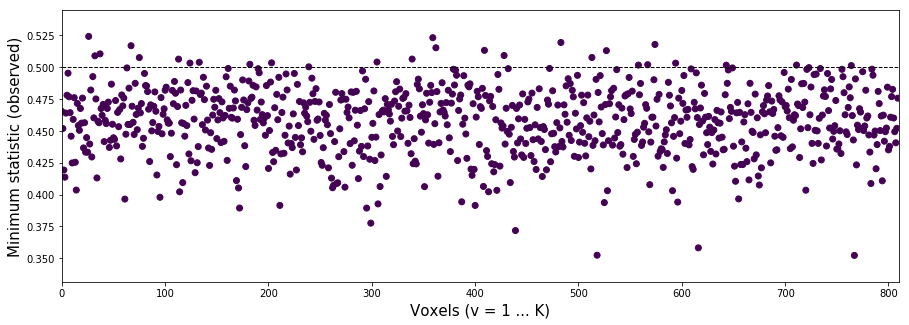

In [4]:
m = np.min(obs, axis=0)
print("Shape of m: %s" % (m.shape,))

plt.figure(figsize=(15, 5))
plt.scatter(np.arange(np.prod(K)), m, c=np.zeros(np.prod(K)))
plt.xlim(0, np.prod(K))
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel("Minimum statistic (observed)", fontsize=15)
plt.axhline(y=0.5, c='k', ls='--', lw=1)
plt.show()

### The global null hypothesis
Now, the global null hypothesis, corresponding to the hypothesis that all subjects' scores are at chance level ($a_{0}$), is formulated as (cf. equation 12):

\begin{align}
H_{0}: \forall_{k}a_{k} = a_{0}
\end{align}

As such, the negation of the null-hypothesis corresponds to the alternative hypothesis (I think, but this is not explicitly stated in the paper), which can be formulated as:

\begin{align}
H_{a}: \exists_{k}a_{k} > a_{0}
\end{align}

which states that there exists one (or more) subject(s) ($\exists_{k}a_{k}$) that have above-chance accuracy.

We can calculate the p-value corresponding to the null-hypothesis for any observed minimum statistic $m_{v}$ at voxel $v$ as:

\begin{align}
P_{N}(m_{v}) = \frac{1}{P_{2} + 1}(1 + \sum_{j=1}^{P_{2}}[m_{v} \leq m_{vj}])
\end{align}

in which $P_{2}$ denotes the number of second-level permutations (*without* the "neutral permutation", i.e., the 'observed' second level statistics) and $m_{vj}$ the minimum statistic of permutation $j$ at voxel $v$. Thus, the p-value here represents the proportion of instances in which the permutation minimum statistic was higher than the observed minimum statistic. 

First, we need to actually run the second-level permutations, which consist of a randomly drawn first-level permutation per subject: 

In [5]:
u_rank = np.zeros(np.prod(K))  # uncorrected
c_rank = np.zeros(np.prod(K))  # corrected
for j in tqdm_notebook(range(P2)):
    these_perms = np.vstack([perms[k, :, np.random.choice(np.arange(P1), size=1)]
                             for k in range(N)])
    min_vals = these_perms.min(axis=0)
    u_rank += m <= min_vals
    c_rank += m <= min_vals.max()

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

Now we can calculate the (uncorrected) p-value for the global null hypothesis (`pu_GN`; we'll do this at once for all voxels) using the values from `u_rank`:

Shape of pu_GN: (810,)
Number of significant voxels: 560


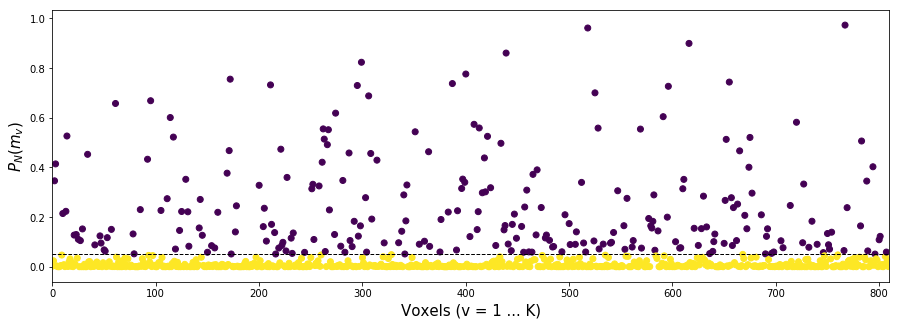

In [6]:
pu_GN = (1 + u_rank) / (P2 + 1)
print("Shape of pu_GN: %s" % (pu_GN.shape,))
print("Number of significant voxels: %i" % (pu_GN < alpha).sum())

plt.figure(figsize=(15, 5))
plt.scatter(np.arange(np.prod(K)), pu_GN, c=(pu_GN < alpha) + 1)
plt.xlim(0, np.prod(K))
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel(r"$P_{N}(m_{v})$", fontsize=15)
plt.axhline(y=alpha, c='k', ls='--', lw=1)
plt.show()

We should, of course, correct for multiple comparisons. This can be done by calculating the *maximum* statistic across all $P_{2}$ permutations. Then, we can use the distribution of maximum statistic values ($M_{j}$ across $j = 1\ ...\ P_{2}$ permutations):

\begin{align}
M_{j} = max_{v}m_{vj}
\end{align}

Then, the *corrected* p-value corresponding to the global null hypothesis (`pc_GN`) can be calculated as:

\begin{align}
P_{N}^{*}(M_{v}) = \frac{1}{P_{2} + 1}(1 + \sum_{j=1}^{P_{2}}[m_{v} \leq M_{j}])
\end{align}

And in code:

Shape of pc_GN: (810,)
Number of significant voxels: 106


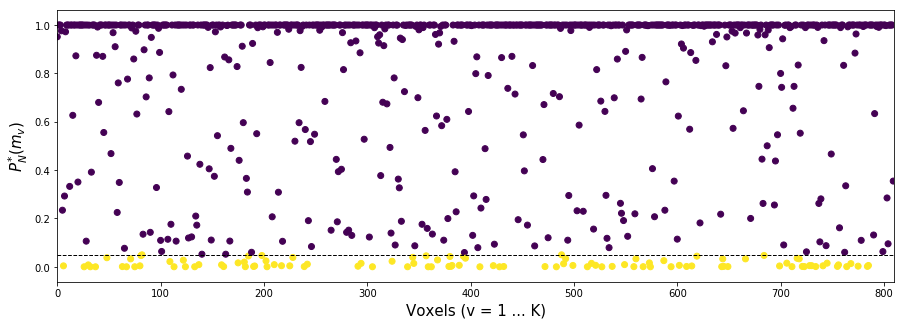

In [7]:
pc_GN = (1 + c_rank) / (P2 + 1)
print("Shape of pc_GN: %s" % (pc_GN.shape,))
print("Number of significant voxels: %i" % (pc_GN < alpha).sum())

plt.figure(figsize=(15, 5))
plt.scatter(np.arange(np.prod(K)), pc_GN, c=pc_GN < alpha)
plt.xlim(0, np.prod(K))
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel(r"$P_{N}^{*}(m_{v})$", fontsize=15)
plt.axhline(y=alpha, c='k', ls='--', lw=1)
plt.show()

### The prevalence null hypothesis
In contrast to the global null hypothesis, the prevalence null hypothesis tests whether the prevalence of an effect is smaller or equal to some threshold prevalence ($\gamma_{0}$):

\begin{align}
H_{0}: \gamma \leq \gamma_{0}
\end{align}

And, correspondingly, the alternative hypothesis becomes (although I'm not sure of this; it's not explicitly in the paper):

\begin{align}
H_{a}: \gamma > \gamma_{0}
\end{align}

We can express the (uncorrected) prevalance null p-value for any threshold $\gamma_{0}$:

\begin{align}
P_{N}(m \mid \gamma \leq \gamma_{0}) = [(1 - \gamma_{0})\ \sqrt[N]{P_{N}(m)} + \gamma_{0}]^{N} 
\end{align}

Let's do that below (we pick $\gamma_{0} = 0.5$, the 'majority null hypothesis'):

Shape of pu_MN: (810,)
Number of significant voxels: 261


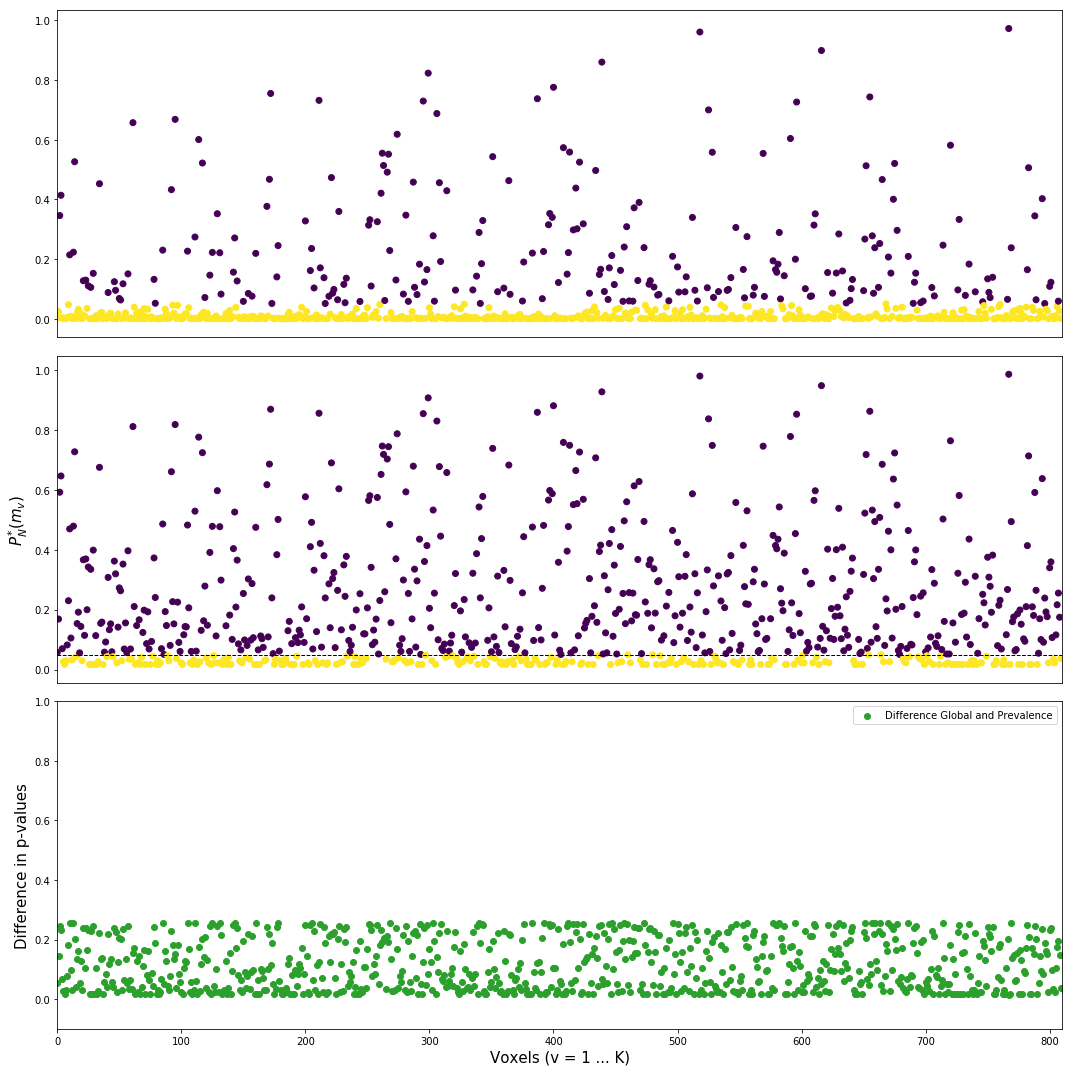

In [8]:
pu_MN = ((1 - gamma0) * pu_GN ** (1 / N) + gamma0) ** N
print("Shape of pu_MN: %s" % (pu_MN.shape,))
print("Number of significant voxels: %i" % (pu_MN < alpha).sum())

plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
plt.scatter(np.arange(np.prod(K)), pu_GN, c=pu_GN < alpha)
plt.xticks([])
plt.xlim(0, np.prod(K))

plt.subplot(3, 1, 2)
plt.scatter(np.arange(np.prod(K)), pu_MN, c=pu_MN < alpha)
plt.xlim(0, np.prod(K))
plt.ylabel(r"$P_{N}^{*}(m_{v})$", fontsize=15)
plt.axhline(y=alpha, c='k', ls='--', lw=1)
plt.xticks([])

plt.subplot(3, 1, 3)
plt.scatter(np.arange(np.prod(K)), pu_MN - pu_GN, c='tab:green')
plt.legend(['Difference Global and Prevalence'])
plt.xlim(0, np.prod(K))
plt.ylim(-.1, 1)
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel("Difference in p-values", fontsize=15)

plt.tight_layout()
plt.show()

As you can see, the p-values of the prevalence hypothesis are more conservative than those corresponding to the global null hypothesis. Of course, given that we test a bunch of voxels, we need to correct for multiple comparisons. This amounts to testing the *spatially extended prevalence null hypothesis*. The formula for the p-value corresponding to this hypothesis is:

\begin{align}
P_{N}^{*}(m \mid \gamma \leq \gamma_{0}) = P_{N}^{*}(m) + [1 - P_{N}^{*}(m)] P_{N}(m \mid \gamma \leq \gamma_{0})
\end{align}

which is implemented below:

Shape of pc_MN: (810,)
Number of significant voxels: 88


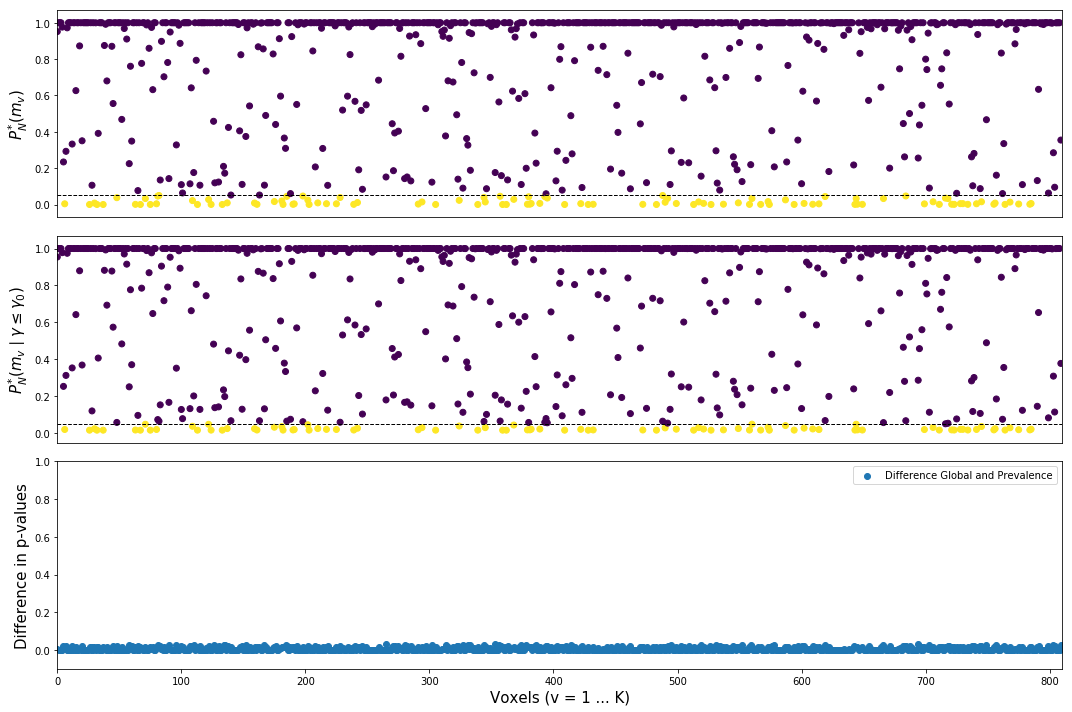

In [9]:
pc_MN = pc_GN + (1 - pc_GN) * pu_MN
print("Shape of pc_MN: %s" % (pc_MN.shape,))
print("Number of significant voxels: %i" % (pc_MN < alpha).sum())

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.scatter(np.arange(np.prod(K)), pc_GN, c=pc_GN < alpha)
plt.xlim(0, np.prod(K))
plt.ylabel(r"$P_{N}^{*}(m_{v})$", fontsize=15)
plt.axhline(y=alpha, c='k', ls='--', lw=1)
plt.xticks([])

plt.subplot(3, 1, 2)
plt.scatter(np.arange(np.prod(K)), pc_MN, c=pc_MN < alpha)
plt.xlim(0, np.prod(K))
plt.ylabel(r"$P_{N}^{*}(m_{v} \mid \gamma \leq \gamma_{0})$", fontsize=15)
plt.axhline(y=alpha, c='k', ls='--', lw=1)
plt.xticks([])

plt.subplot(3, 1, 3)
plt.scatter(np.arange(np.prod(K)), pc_MN - pc_GN)
plt.legend(['Difference Global and Prevalence'])
plt.xlim(0, np.prod(K))
plt.ylim(-.1, 1)
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel("Difference in p-values", fontsize=15)

plt.tight_layout()
plt.show()

Instead of calculating the corrected p-values, we can calculate a corrected $\alpha$ value, i.e. $\alpha^{*}$, and use this threshold for the uncorrected p-values. This threshold is calculated as:

\begin{align}
\alpha^{*} = \frac{\alpha - P_{N}^{*}(m)}{1 - P_{N}^{*}(m)}
\end{align}

We'll calculate this below and use it to threshold the uncorrected p-values and subsequently assert that it yields the same signficant voxels as using the corrected p-values:

pc_MN < alpha and pu_MN < alpha_c yield the same voxels? True


/Users/lukas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


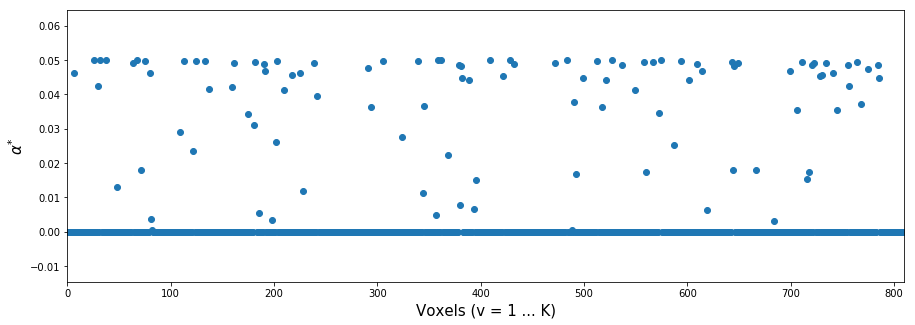

In [10]:
alpha_c = (alpha - pc_GN) / (1 - pc_GN)
alpha_c[np.isinf(alpha_c)] = 0
alpha_c[alpha_c <= 0.0] = 0

same_sig_voxels = np.all((pc_MN < alpha) == (pu_MN < alpha_c))
print("pc_MN < alpha and pu_MN < alpha_c yield the same voxels? %s" % same_sig_voxels)

plt.figure(figsize=(15, 5))
plt.scatter(np.arange(np.prod(K)), alpha_c)
plt.xlim(0, np.prod(K))
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel(r"$\alpha^{*}$", fontsize=15)
plt.show()

### Lower bound of $\gamma_{0}$
Instead of calculating p-values for a prespecified $\gamma_{0}$ value, we can compute the *largest $\gamma_{0}$ value that can be rejected given a particular $\alpha$ value*. As noted in the original article, this value is *not* an estimate of the true $\gamma_{0}$, but it is a lower bound of the ($1 - \alpha$) confidence interval $[\gamma_{0} - 1]$. This largest $\gamma_{0}$ for the uncorrected $\alpha$ is calculated as:

\begin{align}
\gamma_{0} = \frac{\sqrt[N]{\alpha} - \sqrt[N]{P_{N}(m)}}{1 - \sqrt[N]{P_{N}(m)}}
\end{align}

As is done below:

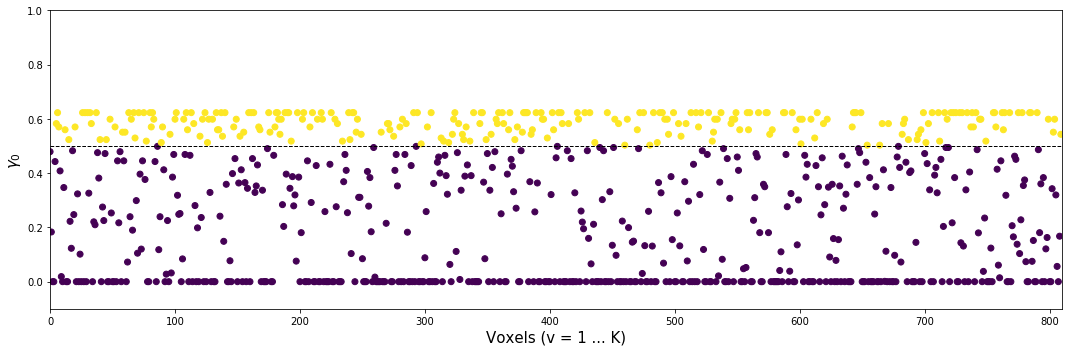

In [11]:
gamma0_u = (alpha ** (1 / N) - pu_GN ** (1 / N)) / (1 - pu_GN ** (1 / N))
gamma0_u[alpha < pu_GN] = 0

plt.figure(figsize=(15, 5))
plt.scatter(np.arange(np.prod(K)), gamma0_u, c=gamma0_u > gamma0)
plt.xlim(0, np.prod(K))
plt.ylabel(r"$P_{N}^{*}(m_{v})$", fontsize=15)
plt.axhline(y=gamma0, c='k', ls='--', lw=1)
plt.xlim(0, np.prod(K))
plt.ylim(-.1, 1)
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel(r"$\gamma_{0}$", fontsize=15)

plt.tight_layout()
plt.show()

Again, if we're testing multiple voxels (like we're doing here), we need to calculate the multiple-comparisons-corrected $\gamma_{0}$ values, let's call it $\gamma_{0}^{*}$, which is calculated using $\alpha^{*}$ from before as:

\begin{align}
\gamma_{0}^{*} = \frac{\sqrt[N]{\alpha^{*}} - \sqrt[N]{P_{N}(m)}}{1 - \sqrt[N]{P_{N}(m)}}
\end{align}

Let's implement this below:

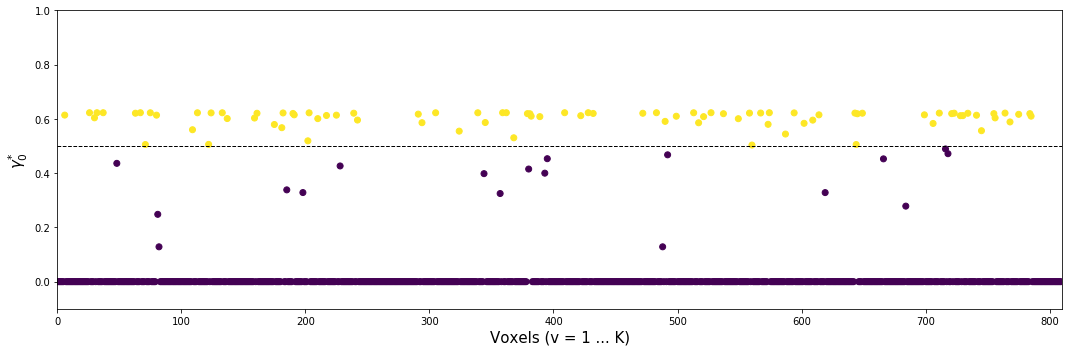

In [12]:
gamma0_c = (alpha_c ** (1 / N) - pu_GN ** (1 / N)) / (1 - pu_GN ** (1 / N))
gamma0_c[alpha_c < pu_GN] = 0

plt.figure(figsize=(15, 5))
plt.scatter(np.arange(np.prod(K)), gamma0_c, c=gamma0_c > gamma0)
plt.xlim(0, np.prod(K))
plt.ylabel(r"$P_{N}^{*}(m_{v})$", fontsize=15)
plt.axhline(y=gamma0, c='k', ls='--', lw=1)
plt.xlim(0, np.prod(K))
plt.ylim(-.1, 1)
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel(r"$\gamma_{0}^{*}$", fontsize=15)

plt.tight_layout()
plt.show()

As you can see in the plot above, there seems to be some kind of upper limit to $\gamma_{0}^{*}$, around .62 or so. This is due to the fact that, as described in the original article, this statistic next to the number of subjects ($N$) and the significance level ($\alpha$) also depends on the amount of permutations ($P2$). Indeed, the maximum $\gamma_{0}$ value you can be computed as follows:

\begin{align}
y_{0\ max} = \frac{\sqrt[N]{\alpha^{*}_{max}} - \sqrt[N]{1\ /\ P_{2}}}{1 - \sqrt[N]{1\ /\ P_{2}}}
\end{align}

with $\alpha^{*}_{max}$ defined as:

\begin{align}
\alpha^{*}_{max} = \frac{\alpha - 1\ /\ \mathrm{P_{2}}}{1 - 1\ /\ \mathrm{P_{2}}}
\end{align}

We'll implement this below for both the uncorrected and the corrected statistics (for the uncorrected statistic, we simply swap $\alpha_{max}^{*}$ with $\alpha$):

In [13]:
gamma0_max_u = (alpha ** (1 / N) - 1 / P2 ** (1 / N)) / (1 - 1 / P2 ** (1 / N))
alpha_max_c = (alpha - 1 / P2) / (1 - 1 / P2)
gamma0_max_c = (alpha_max_c ** (1 / N) - 1 / P2 ** (1 / N)) / (1 - 1 / P2 ** (1 / N))

print("Maximum statistic uncorrected: %.8f" % gamma0_max_u)
print("Maximum statistic corrected: %.8f" % gamma0_max_c)

Maximum statistic uncorrected: 0.62305620
Maximum statistic corrected: 0.62283437


Let's check how many voxels actually (approximately) reach this upper bound:

In [14]:
perc_upperbound_u = np.mean(np.abs(gamma0_u - gamma0_max_u) < 0.01) * 100
perc_upperbound_c = np.mean(np.abs(gamma0_c - gamma0_max_c) < 0.01) * 100

print("Percentage of voxels reaching upper bound (uncorrected): %.3f" % perc_upperbound_u)
print("Percentage of voxels reaching upper bound (corrected): %.3f" % perc_upperbound_c)

Percentage of voxels reaching upper bound (uncorrected): 13.086
Percentage of voxels reaching upper bound (corrected): 6.296


### Comparison with second-level t-test
Let's check what the actual second-level t-value would yield in terms of p-values. First the non-parametric version:

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

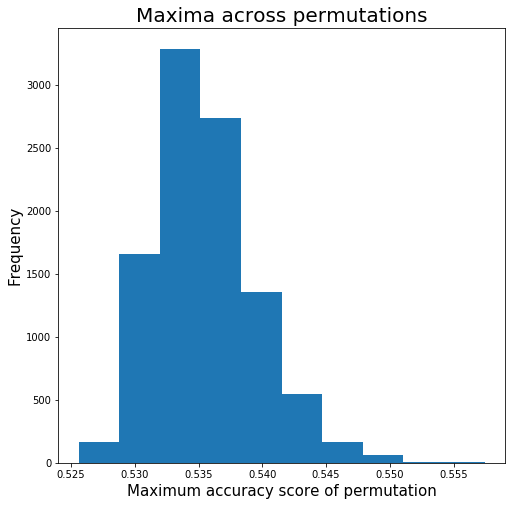

In [15]:
perm_stats = np.zeros((np.prod(K), P2))
for j in tqdm_notebook(range(P2)):
    these_perms = np.vstack([perms[k, :, np.random.choice(np.arange(P1), size=1)]
                             for k in range(N)])
    perm_stats[:, j] = these_perms.mean(axis=0)
perm_max = np.max(perm_stats, axis=0)

plt.figure(figsize=(8, 8))
plt.hist(perm_max)
plt.title("Maxima across permutations", fontsize=20)
plt.xlabel("Maximum accuracy score of permutation", fontsize=15)
plt.ylabel("Frequency", fontsize=15)

plt.show()

Number of significant voxels (uncorrected): 809
Number of significant voxels (corrected): 596


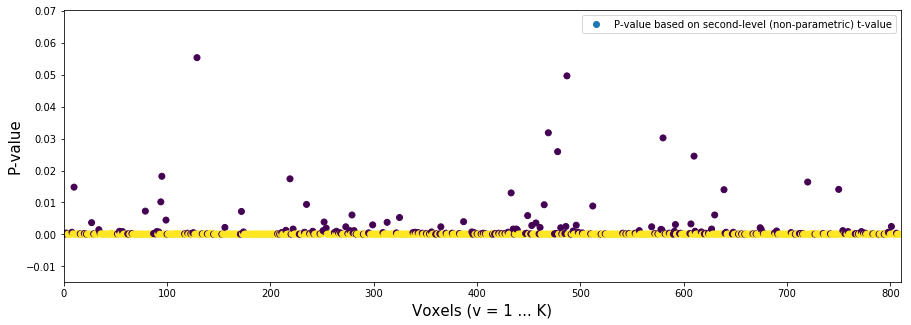

In [16]:
pu_regular = (1 + np.sum(obs.mean(axis=0)[:, np.newaxis] < perm_stats, axis=1)) / (P2 + 1)
print("Number of significant voxels (uncorrected): %i" % (pu_regular < alpha).sum())

cutoff_mc = np.percentile(perm_max, q=95)
print("Number of significant voxels (corrected): %i" % ((obs.mean(axis=0) > cutoff_mc).sum()))

plt.figure(figsize=(15, 5))
plt.scatter(np.arange(np.prod(K)), pu_regular, c=(obs.mean(axis=0) > cutoff_mc))
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel('P-value', fontsize=15)
plt.xlim(0, np.prod(K))
plt.legend(["P-value based on second-level (non-parametric) t-value"])
plt.show()

And the parametric one (corrected for multiple comparisons using Bonferroni correction):

Number of significant voxels (uncorrected): 803
Number of significant voxels (corrected): 270


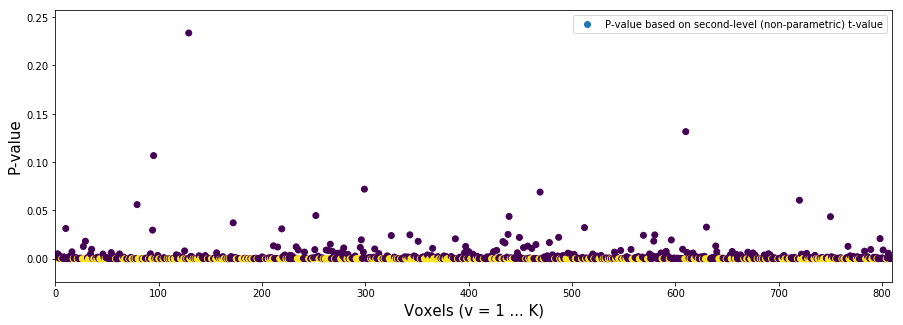

In [17]:
tu_regular_parametric, pu_regular_parametric = stats.ttest_1samp(obs, axis=0, popmean=0.5)
print("Number of significant voxels (uncorrected): %i" % (pu_regular_parametric < alpha).sum())
print("Number of significant voxels (corrected): %i" % (pu_regular_parametric < alpha/pu_regular_parametric.size).sum())

plt.figure(figsize=(15, 5))
plt.scatter(np.arange(np.prod(K)), pu_regular_parametric, c=pu_regular_parametric < alpha/pu_regular_parametric.size)
plt.xlabel("Voxels (v = 1 ... K)", fontsize=15)
plt.ylabel('P-value', fontsize=15)
plt.xlim(0, np.prod(K))
plt.legend(["P-value based on second-level (non-parametric) t-value"])
plt.show()

As you can see, a regular second level t-test on MVPA metrics yields much more significant results (voxels) than the prevalance method, as you would expect given that second level t-tests essentially implement a fixed-effects analysis. 

Now, let's validate this Python implementation on the same data from the article by [Cichy et al. (2011)](http://www.sciencedirect.com/science/article/pii/S1053811910012255?via%3Dihub), available from Carsten Allefeld's [Github](https://github.com/allefeld/cichy-2011-category-smoothedaccuracy/releases/tag/v1.0.0).

## Check real data (Cichy et al., 2011)
Check whether we get (approximately) the same output as the original implementation in MATLAB.

In [18]:
from glob import glob
import os.path as op

data_dir = '../prevalence-permutation/cichy-2011-category-smoothedaccuracy-1.0.0/'
sub_dirs = sorted(glob(op.join(data_dir, '??')))

all_data = []

for sub_dir in tqdm_notebook(sub_dirs):
    
    perm_files = sorted(glob(op.join(sub_dir, '*')))
    all_data.append([nib.load(p).get_data().ravel() for p in perm_files])

all_data = np.stack([np.stack(all_data[i], axis=-1) for i in range(len(all_data))], axis=0)
print("Shape of all data: %s" % (all_data.shape,))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))


Shape of all data: (12, 902629, 16)


Let's remove all NaN values (this mask contains the same amount of voxels as calculated by the MATLAB toolbox):

In [19]:
mask = ~(np.isnan(all_data).sum(axis=(0, 2)) > 0)
all_data_nonzero = all_data[:, mask, :]

print("Shape of masked data: %s" % (all_data_nonzero.shape,))

Shape of masked data: (12, 48999, 16)


And split the data into the 'real' (observed) statistics ($i = 1$) and the permuted statistics ($i = 2\ ...\ 16$). Note that we'll append all variable names with `_r` to denote that these correspond to the "real" data/parameters.

In [20]:
obs_r = all_data_nonzero[:, :, 0]
perms_r = all_data_nonzero[:, :, 1:]

print("Observed data shape: %s" % (obs_r.shape,))
print("Permuted data shape: %s" % (perms_r.shape,))

N_r, K_r, P1_r = perms_r.shape
P2_r = 200000

Observed data shape: (12, 48999)
Permuted data shape: (12, 48999, 15)


And let's run the second level permutations with $P_{2} = 20,000$. This is 10 times fewer than the results from the MATLAB toolbox (and least, the way I ran it), but it should suffice.

In [21]:
m_r = np.min(obs_r, axis=0)
u_rank_r = np.zeros(K_r)
c_rank_r = np.zeros(K_r)
for j in tqdm_notebook(range(P2_r)):
    these_perms = np.vstack([perms_r[k, :, np.random.choice(np.arange(P1_r), size=1)]
                             for k in range(N_r)])
    min_vals = these_perms.min(axis=0)
    u_rank_r += m_r <= min_vals
    c_rank_r += m_r <= min_vals.max()

HBox(children=(IntProgress(value=0, max=200000), HTML(value='')))

In [22]:
pu_GN_r = (1 + u_rank_r) / (P2_r + 1)
pc_GN_r = (1 + c_rank_r) / (1 + P2_r)
pu_MN_r = ((1 - gamma0) * pu_GN_r ** (1 / N_r) + gamma0) ** N_r
pc_MN_r = pc_GN_r + (1 - pc_GN_r) * pu_MN_r

sig_pu_GN = (pu_GN_r < alpha).sum()
sig_pc_GN = (pc_GN_r < alpha).sum()
sig_pu_MN = (pu_MN_r < alpha).sum()
sig_pc_MN = (pc_MN_r < alpha).sum()

print("Number of significant voxels GLOBAL NULL "
      "(uncorrected): %i (%.1f %%)" % (sig_pu_GN, (sig_pu_GN / K_r) * 100))

print("Number of significant voxels GLOBAL NULL "
      "(corrected): %i (%.1f %%)" % (sig_pc_GN, (sig_pc_GN / K_r) * 100))

print("Number of significant voxels MAJORITY NULL "
      "(uncorrected): %i (%.1f %%)" % (sig_pu_MN, (sig_pu_MN / K_r) * 100))

print("Number of significant voxels MAJORITY NULL "
      "(corrected): %i (%.1f %%)" % (sig_pc_MN, (sig_pc_MN / K_r) * 100))

Number of significant voxels GLOBAL NULL (uncorrected): 26113 (53.3 %)
Number of significant voxels GLOBAL NULL (corrected): 13616 (27.8 %)
Number of significant voxels MAJORITY NULL (uncorrected): 19839 (40.5 %)
Number of significant voxels MAJORITY NULL (corrected): 13491 (27.5 %)


These percentages at least correspond to what is stated in the article ("The spatially extended global null hypothesis of no information in any subject in the population can be rejected at a level
of a = 0.05 in about 27% of in-mask voxels", p. 387). Now, let's calculte the maximum $\gamma_{0}$ parameters given our $\alpha$ level:

In [23]:
gamma0_u_r = (alpha ** (1 / N_r) - pu_GN_r ** (1 / N_r)) / (1 - pu_GN_r ** (1 / N_r))
gamma0_u_r[alpha < pu_GN_r] = 0

alpha_c_r = (alpha - pc_GN_r) / (1 - pc_GN_r)
alpha_c_r[np.isinf(alpha_c_r)] = 0
alpha_c_r[alpha_c_r <= 0.0] = 0

gamma0_c_r = (alpha_c_r ** (1 / N_r) - pu_GN_r ** (1 / N_r)) / (1 - pu_GN_r ** (1 / N_r))
gamma0_c_r[alpha_c_r < pu_GN_r] = 0

gamma0_max_u_r = (alpha ** (1 / N_r) - 1 / P2_r ** (1 / N_r)) / (1 - 1 / P2_r ** (1 / N_r))
alpha_max_c_r = (alpha - 1 / P2_r) / (1 - 1 / P2_r)
gamma0_max_c_r = (alpha_max_c_r ** (1 / N_r) - 1 / P2_r ** (1 / N_r)) / (1 - 1 / P2_r ** (1 / N_r))

print("Maximum gamma (corrected) possible: %.3f" % gamma0_max_c_r)

Maximum gamma (corrected) possible: 0.654


/Users/lukas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/lukas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/lukas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


Note that the maximum $\gamma_{0}^{*}$ value is lower than reported in the article (i.e., 0.701), but this because we used $20000$ second level permutations, and the article used $10^7$. 

In [24]:
perc_upperbound_r = np.mean(np.abs(gamma0_c_r - gamma0_max_c_r) < 0.01) * 100
print("Percentage of voxels reaching upper bound: %.3f" % perc_upperbound_r)

Percentage of voxels reaching upper bound: 25.674


Again, this is lower than in the article (they mention around 50% of the voxels reaching upper bound), but I suspect this is again due to the amound of permutations.

### Recreate original brain plots
Let's try to recreate the brain plots from the original article. In Figure 4, they plot 3 different brain plots (based on different data/parameters/statistics). 

#### Figure 4a
In the left panel (Figure 4a), they plot the $\gamma_{0}^{*}$ values (I assume they plot the corrected values). Let's recreate that with our own analysis data:

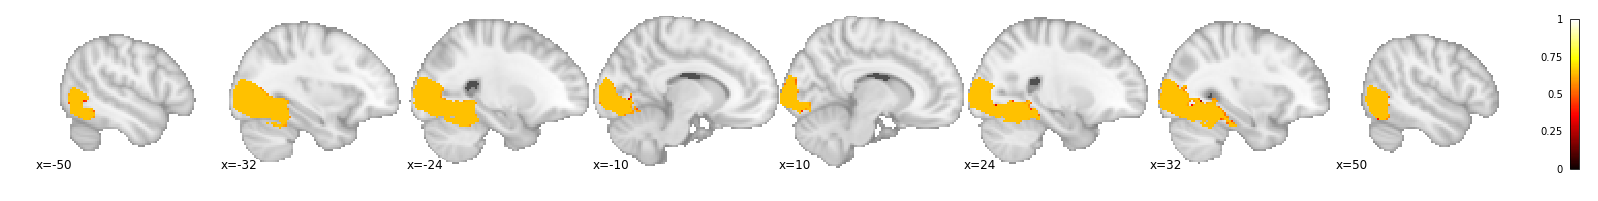

In [25]:
# Some general plotting parameters
tmp = nib.load(perm_files[0])
affine = tmp.affine
vol_shape = tmp.shape
cut_coords = [-50, -32, -24, -10, 10, 24, 32, 50]

gamma0_c_r_img = np.zeros(vol_shape).ravel()
gamma0_c_r_img[mask] = gamma0_c_r
gamma0_c_r_img = nib.Nifti1Image(gamma0_c_r_img.reshape(vol_shape), affine=affine)

plot_stat_map(gamma0_c_r_img, display_mode='x', vmax=1,
              cut_coords=cut_coords)
plt.show()

Looks similar! Now, let's quantify this similarity:

In [26]:
# This file was calculated by the MATLAB toolbox
gamma0_c_ML = nib.load('../prevalence-permutation/prevalence_gamma0c.nii').get_data().ravel()
gamma0_c_ML[np.isnan(gamma0_c_ML)] = 0

corr, p = stats.pearsonr(gamma0_c_r, gamma0_c_ML[mask])
print("Correlation (p-val) Python and MATLAB version: %.3f (%.3f)" % (corr, p))

dev = np.abs(gamma0_c_r - gamma0_c_ML[mask])
print("Mean (std) absolute deviation: %.3f (%.3f)" % (dev.mean(), dev.std()))

Correlation (p-val) Python and MATLAB version: 0.995 (0.000)
Mean (std) absolute deviation: 0.003 (0.029)


#### Figure 4b
In the middle panel (Figure 4b), they plot median classification accuracy for the voxels in which the majority prevalence null hypothesis can be rejected ($H_{0}: \gamma \leq 0.5$):

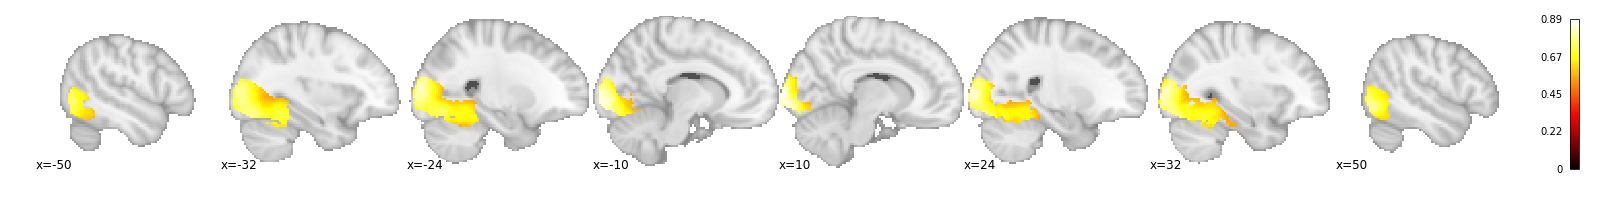

In [27]:
scores_typical = np.median(obs_r, axis=0)
scores_typical[pc_MN_r > alpha] = 0

typical_scores_img = np.zeros(vol_shape).ravel()
typical_scores_img[mask] = scores_typical
typical_scores_img = nib.Nifti1Image(typical_scores_img.reshape(vol_shape), affine=affine)

plot_stat_map(typical_scores_img, display_mode='x',
              cut_coords=cut_coords)
plt.show()

And let's quantify the similarity again:

In [28]:
# This file was calculated by the MATLAB toolbox
scores_typical_ML = nib.load('../prevalence-permutation/prevalence_aTypical.nii').get_data()
pc_MN_ML = nib.load('../prevalence-permutation/prevalence_pcMN.nii').get_data()

scores_typical_ML[np.isnan(scores_typical_ML)] = 0
pc_MN_ML[np.isnan(pc_MN_ML)] = 0
scores_typical_ML[pc_MN_ML > alpha] = 0

corr, p = stats.pearsonr(scores_typical, scores_typical_ML.ravel()[mask])
print("Correlation (p-val) Python and MATLAB version: %.3f (%.3f)" % (corr, p))

dev = np.abs(gamma0_c_r - gamma0_c_ML[mask])
print("Mean (std) absolute deviation: %.3f (%.3f)" % (dev.mean(), dev.std()))

Correlation (p-val) Python and MATLAB version: 0.992 (0.000)
Mean (std) absolute deviation: 0.003 (0.029)


#### Figure 4c
In the right panel (Figure 4c), they plot the results from a second level t-test on the first level classification accuracies. They don't mention how they did this, so let's just use an (SPM-style) RFX-analysis (but, as argued in the article, it's effectively an FFX-analysis):

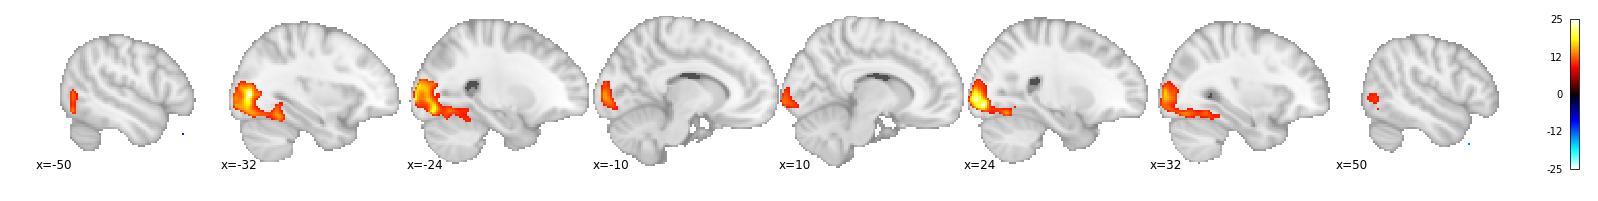

In [29]:
tval_rfx, pu_rfx = stats.ttest_1samp(obs_r, axis=0, popmean=0.5)
tval_rfx[pu_rfx > (alpha / obs_r.shape[1])] = 0  # Bonferroni correction

tstat_img = np.zeros(vol_shape).ravel()
tstat_img[mask] = tval_rfx
tstat_img = nib.Nifti1Image(tstat_img.reshape(vol_shape), affine=affine)

plot_stat_map(tstat_img, display_mode='x', cut_coords=cut_coords, vmax=25)
plt.show()